# Barabási-Albert's Small-World network
## Overview
The code below implements the Barabási-Albert algorithm for creating small-world networks. Your task is to experiment with different parameter settings and figure out how the parameter values affect the graph structure.

In [1]:
#
# NOTE: This cell contains the function for making animations in CoCalc.
#       You do not have to work through this code. Start at the next cell.
#

def make_animation(draw_function, frames, interval, filename=None,
                   verbose=False, figure_params=None):
    """
    Write an animated GIF to file using matplotlib and ImageMagick.

    Inputs:

        draw_function (callable) The function to call, once per frame,
          to render to the current matplotlib figure. This function's call
          signature must be

            draw_function(current_frame_number, total_frame_count)

          The first frame is 0 and the last frame is total_frame_count-1.

        frames (int) The number of frames to generate.

        interval (float) The number of milliseconds to wait between frames
          in the animation. Set this to 40 for a fairly standard frame rate
          of 25fps (1 second / 40 (milliseconds per frame) = 25 frames per
          second).

        filename (str) The path to the file to write to. If none is provided,
          the animation will be written to a random filename, prefixed with
          "animate_" in the current directory. Default: None.

        verbose (bool) Whether to print the current frame number to the
          console as the animation is being created. This will clear other
          console output. Default: False.

        figure_params (dict) The keyword arguments to pass to matplotlib
          when creating a new figure for this animation. Use it to set the
          figure size and other figure properties. Default: None.

    Returns: A display object that will inject HTML for displaying the
      animated GIF into the notebook.
    """
    from matplotlib import pyplot, animation
    from IPython.display import HTML, display, clear_output
    import random

    if filename is None:
        filename = 'animate_%06i.gif' % random.randint(0, 999999)
    # Create figure
    if figure_params is None:
        figure_params = {}
    figure = pyplot.figure(**figure_params)
    # Wrap draw_function if we need to print to console
    if verbose:
        old_draw_function = draw_function
        def draw_function(current_frame_number, total_frame_count):
            old_draw_function(current_frame_number, total_frame_count)
            print('Processed frame', current_frame_number + 1, '/', total_frame_count)
            clear_output(wait=True)
            if current_frame_number + 1 == total_frame_count:
                print('Writing animation to file...')
                clear_output(wait=True)
    # Generate animation
    anim = animation.FuncAnimation(
        figure, draw_function, frames=frames, interval=interval,
        init_func=lambda: None, fargs=(frames,))
    anim.save(filename, writer='imagemagick')
    # Close the animation figure so the last frame does not get displayed
    # in the notebook.
    pyplot.close()
    # Return display object for the animated GIF
    return display(HTML('<img src="' + filename + '">'))

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np


class BarabasiAlbertSimulation:
    '''
    An implementation of the Barabasi-Albert algorithm for
    constructing small-world graphs.
    '''

    def __init__(self, initial_nodes=5, new_node_degree=2):
        '''
        Inputs:

            initial_nodes (int) The number of nodes from which
              the small-world graph starts growing. A complete
              graph with this many nodes will be created when
              the initialize() method below is called.
              Default: 5.

            new_node_degree (int) Every new node that is added
              to the graph will be connected to this many nodes
              in the existing graph.
        '''
        if initial_nodes < new_node_degree:
            raise ValueError(
                'Need at least as many initial nodes (%r) as the new node degree (%r)' %
                (initial_nodes, new_node_degree))
        self.initial_nodes = initial_nodes
        self.new_node_degree = new_node_degree

    def initialize(self):
        '''
        Create a new graph for the simulation, using the model parameters.
        '''
        self.graph = nx.complete_graph(self.initial_nodes)
        self.layout = nx.spring_layout(self.graph)

    def observe(self):
        '''
        Update the matplotlib figure for the simulation visualization.
        '''
        plt.clf()
        # Plot network layout, color coding nodes by their degree
        plt.subplot(1, 3, 1)
        degree = np.array([self.graph.degree[i] for i in self.graph.nodes])
        nx.draw(
            self.graph, pos=self.layout,
            node_color=-degree, alpha=0.8)
        plt.title('Nodes: ' + str(len(degree)))
        # Histogram of shortest path lengths between all pairs of nodes
        plt.subplot(1, 3, 2)
        lengths = []
        for source, source_lengths in nx.all_pairs_shortest_path_length(self.graph):
            lengths.extend(x[1] for x in source_lengths.items() if x[0] > source)
        plt.hist(lengths, bins=10, range=(0.5, 10.5), rwidth=0.8)
        plt.title('Shortest path distribution')
        # Histogram of degrees of all nodes
        plt.subplot(1, 3, 3)
        plt.hist(degree, bins=10, range=(0.5, 10.5), rwidth=0.8)
        plt.title('Degree distribution')

    def pref_select(self, nodes):
        '''
        Select a random node from `nodes` with probability proportional to
        the degree of the node.
        '''
        degree = np.array([self.graph.degree[i] for i in nodes])
        cumulative = degree.cumsum()
        index = cumulative.searchsorted(np.random.uniform(0, cumulative[-1]))
        return nodes[index]

    def update(self):
        '''
        Add one new node to the existing graph and connect it to existing
        nodes using preferential attachment.
        '''
        nodes = list(self.graph.nodes)
        newcomer = max(nodes) + 1
        for i in range(self.new_node_degree):
            # Pick a target node using preferential attachment and remove
            # it from the `nodes` list so we can't pick it again.
            target = self.pref_select(nodes)
            self.graph.add_edge(newcomer, target)
            nodes.remove(target)
        # Update graph layout
        self.layout[newcomer] = (0, 0)
        self.layout = nx.spring_layout(self.graph, pos=self.layout)

## New node with 1 edge

In [7]:
sim = BarabasiAlbertSimulation(new_node_degree=1)
sim.initialize()

def animate_simulation(frame, total_frames):
    sim.update()
    sim.observe()

make_animation(
    animate_simulation, frames=100, interval=250,
    figure_params={'figsize': (14, 4)},
    verbose=True)

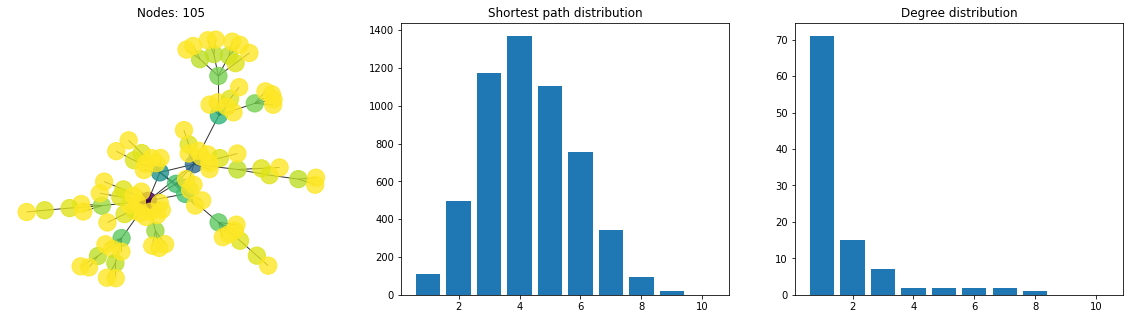

In [8]:
plt.figure(figsize=(20, 5))
sim.observe()

## New node with 3 edges

In [9]:
sim = BarabasiAlbertSimulation(new_node_degree=3)
sim.initialize()

def animate_simulation(frame, total_frames):
    sim.update()
    sim.observe()

make_animation(
    animate_simulation, frames=100, interval=250,
    figure_params={'figsize': (14, 4)},
    verbose=True)

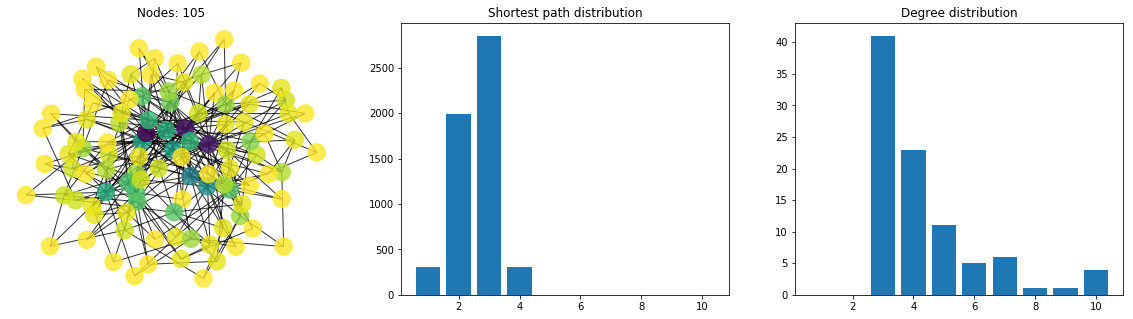

In [10]:
plt.figure(figsize=(20, 5))
sim.observe()

## New node with 5 edges

In [11]:
sim = BarabasiAlbertSimulation(new_node_degree=5)
sim.initialize()

def animate_simulation(frame, total_frames):
    sim.update()
    sim.observe()

make_animation(
    animate_simulation, frames=100, interval=250,
    figure_params={'figsize': (14, 4)},
    verbose=True)

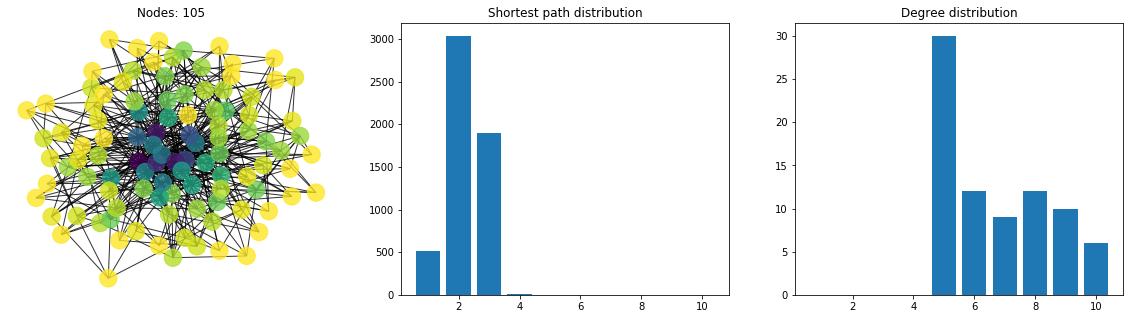

In [12]:
plt.figure(figsize=(20, 5))
sim.observe()

You can create a ready-made Barabási-Albert graph using the `networkx` function `barabasi_albert_graph(n, m)` where `n` is the total number of nodes and `m` is the number of edges by which each newcomer node is connected to the graph.

Generate graphs of different sizes and check that the degree distribution of the graph follows a power law distribution.

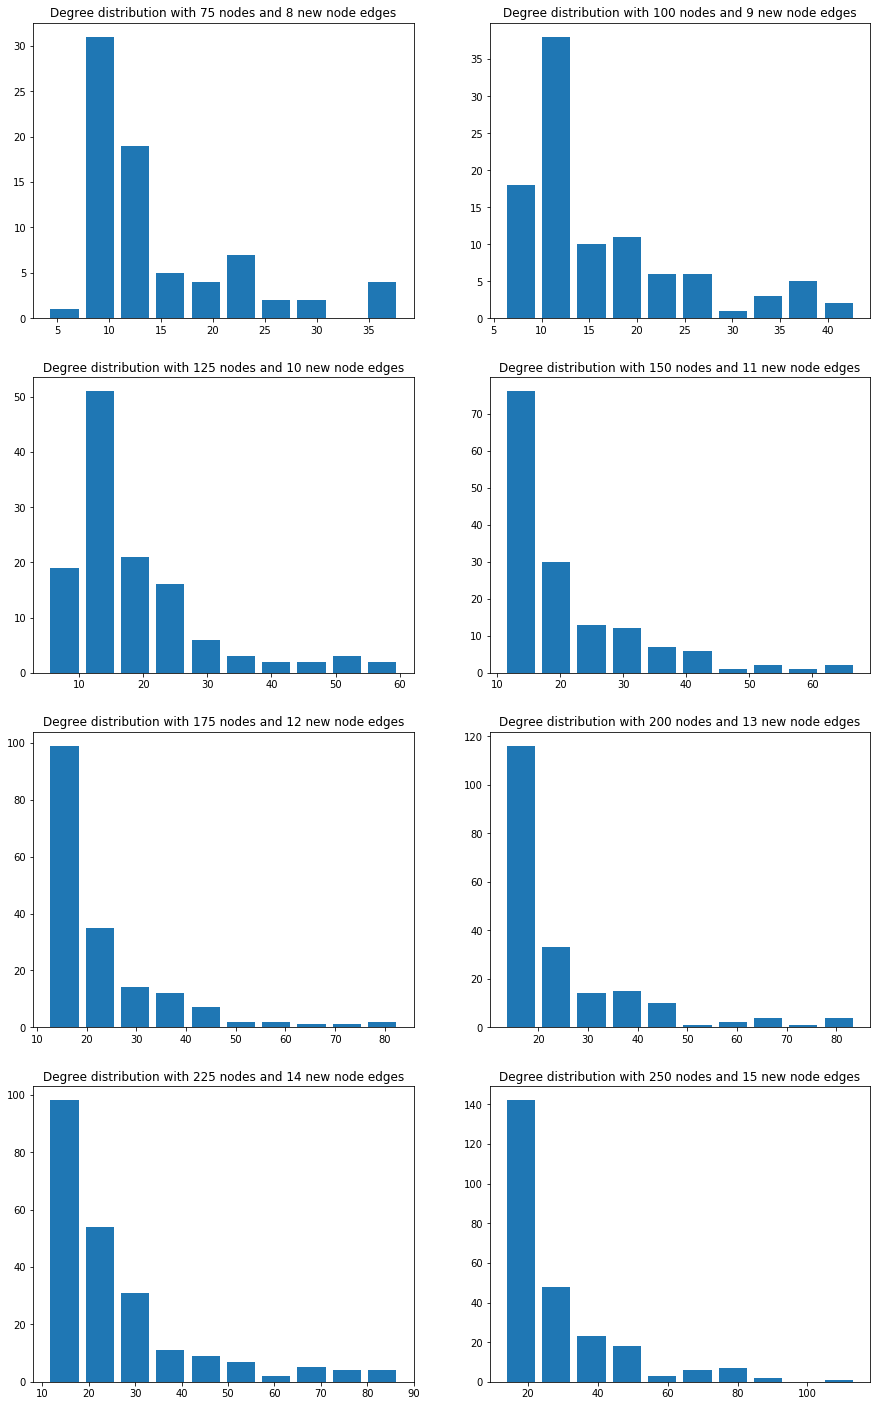

In [47]:
plt.figure(figsize=(15, 25))
for i in range(1, 9):
    plt.subplot(4, 2, i)
    G = nx.barabasi_albert_graph((i+2)*25, (i+2)+5)
    degree = np.array([G.degree[i] for i in G.nodes])
    plt.hist(degree, rwidth=0.8, bins=10)
    plt.title('Degree distribution with {} nodes and {} new node edges'.format(
        (i+2)*25, (i+2)+5))